In [1]:
import torch
import os
import struct
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import copy


In [2]:

def read_all_images(path_to_data):
   """
   :param path_to_data: the file containing the binary images from the STL-10 dataset
   :return: an array containing all the images
   """

   with open(path_to_data, 'rb') as f:
       # read whole file in uint8 chunks
       everything = np.fromfile(f, dtype=np.uint8)

       images = np.reshape(everything, (-1, 3, 96, 96))
       

       images = np.transpose(images, (0, 3, 2, 1))
       images =  np.dot(images[:,:,:,0:3],[0.299,0.587,0.114])
       print(images.shape)
       images = np.reshape(images, (len(images), 96*96))
       return images
images = read_all_images(os.getcwd()+"/data/stl10_binary/train_X.bin")


(5000, 96, 96)


In [6]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(96*96, 96*48),
            nn.ReLU(True),
            nn.Linear(96*48, 48*48),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(48*48,48*96),
            nn.ReLU(True),
            nn.Linear(48*96,96*96))
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = autoencoder().cuda()
criterion = nn.MSELoss()
num_epochs = 100
batch_size = 100
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [7]:
lo =[]
for epoch in range(num_epochs):
    for i in range(0,5000, batch_size):
        batch_x = images[i:i+500]
        batch_x = Variable(torch.cuda.FloatTensor(batch_x)).cuda()
        
        output = model(batch_x)
        loss = criterion(output, batch_x)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data[0]))
    lo.append(loss.data[0])
#torch.save(model, './full_new_autoencoder.pth')

/home/mohit1_aml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  
/home/mohit1_aml/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


epoch [1/100], loss:2747.7778
epoch [2/100], loss:2127.6912
epoch [3/100], loss:1783.0096
epoch [4/100], loss:1611.5458
epoch [5/100], loss:1435.5934
epoch [6/100], loss:1350.7937
epoch [7/100], loss:1288.6677
epoch [8/100], loss:1228.7451
epoch [9/100], loss:1188.5754
epoch [10/100], loss:1131.3086
epoch [11/100], loss:1094.1404
epoch [12/100], loss:1062.4716
epoch [13/100], loss:1034.8165
epoch [14/100], loss:1004.9896
epoch [15/100], loss:979.5984
epoch [16/100], loss:954.9803
epoch [17/100], loss:934.5781
epoch [18/100], loss:911.6762
epoch [19/100], loss:884.4239
epoch [20/100], loss:863.7332
epoch [21/100], loss:845.4066
epoch [22/100], loss:830.5046
epoch [23/100], loss:809.4958
epoch [24/100], loss:792.9012
epoch [25/100], loss:778.9006
epoch [26/100], loss:765.5090
epoch [27/100], loss:749.5656
epoch [28/100], loss:736.0229
epoch [29/100], loss:722.7300
epoch [30/100], loss:709.7524
epoch [31/100], loss:696.8722
epoch [32/100], loss:688.4952
epoch [33/100], loss:672.4913
epoch

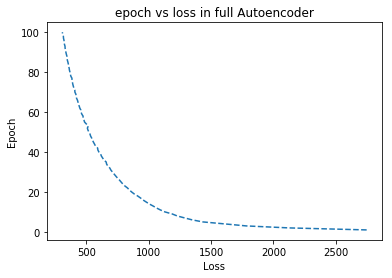

In [19]:
ep = [i+1 for i in range(100)]
plt.plot(lo,ep,linestyle='dashed')
### plot ROC
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.title('epoch vs loss in full Autoencoder')
plt.show()

In [15]:
import matplotlib.pyplot as plt
plt.imshow(images[40].reshape(96,96), interpolation='none')
model1 = torch.load("./funn_autoencoder.pth")
images_reconstructed = model1.encoder(Variable(torch.FloatTensor(images)))
images_reconstructed = model1.decoder(Variable(torch.FloatTensor(images_reconstructed)))
#plt.imshow(images_reconstructed[1].data.numpy().reshape(96,96), interpolation='none')


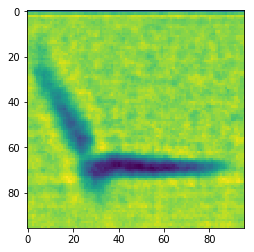

In [6]:
plt.imshow(images_reconstructed[40].data.numpy().reshape(96,96), interpolation='none')

In [40]:
# torch.save(model,"./full_new_autoencoder.pth")
# model = torch.load("./full_new_autoencoder.pth")
feature_rep = model.encoder(Variable(torch.cuda.FloatTensor(images)))


class nu_net(nn.Module):
   def __init__(self,features):
       super(nu_net,self).__init__()
       self.features=features
       self.arch=nn.Sequential(
               nn.Linear(features,int(features/2)),
               nn.ReLU(),
               nn.Linear(int(features/2),int(features/4)),
               nn.ReLU(),
               nn.Linear(int(features/4),10),
               nn.Softmax()
       )
   def forward(self,x):
       x = self.arch(x)
       return x

nn_epoch=100
classifier = nu_net(2304).cuda()
optimizer_nn = torch.optim.SGD(classifier.parameters(), lr=0.01)
criterion_nn = torch.nn.MSELoss()


# class NN(nn.Module):
#   def __init__(self,input_size, hidden_size1,hidden_size2, num_classes):
#         super(NN, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.relu = nn.ReLU(True)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.output = nn.Linear(hidden_size2, num_classes)
#         self.softmax = nn.Softmax()
        
#   def forward(self, x):
        
#         out = self.fc1(x)
#         out = self.relu(out)
#         out = self.fc2(out)
#         out = self.relu(out)
#         out = self.output(out)
#         out = self.softmax(out)
        
#         return out
  

# NeuralNet = NN(48*48, 48*24,24*24,10).cuda()
# criterion_net = nn.MSELoss()
# learning_rate=0.001
# optimizer_net = torch.optim.SGD(NeuralNet.parameters(), lr=learning_rate)

In [45]:
import os
import numpy as np
def read_all_labels(path_to_data):
   """
   :param path_to_data: the file containing the binary images from the STL-10 dataset
   :return: an array containing all the images
   """

   with open(path_to_data, 'rb') as f:
       # read whole file in uint8 chunks
       everything = np.fromfile(f, dtype=np.uint8)

       return everything


label = read_all_labels(os.getcwd()+"/data/stl10_binary/train_y.bin")
epochs = 100
label_oh = np.zeros((label.size,label.max()))
label_oh[np.arange(5000),label-1]=1
label=label-1
label = Variable(torch.cuda.FloatTensor(label))
label_oh = Variable(torch.cuda.FloatTensor(label_oh))
    

In [46]:
for epoch in range(nn_epoch):
   pred_labels = classifier(feature_rep)
   loss=criterion_nn(label_oh,pred_labels)
   print('epoch: ', epoch,' loss: ', loss.item())
   optimizer.zero_grad()
   loss.backward(retain_graph=True)
   optimizer.step()


# for epoch in range(num_epochs):
#     batch_x =feature_rep
#     output = NeuralNet(batch_x)
#     output = output.cpu().detach().numpy()
#     output = Variable(torch.cuda.FloatTensor(output),requires_grad=True)
#     label_batch = label_oh
#     label_batch = Variable(torch.cuda.FloatTensor(label_batch))
#     loss_net = criterion_net(output,label_batch)
# #     print(loss)
#     optimizer_net.zero_grad()
#     loss_net.backward()
#     optimizer_net.step() 
#     print (loss, "  in epoch  ", epoch)

/home/mohit1_aml/anaconda3/envs/mohitpy36/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch:  0  loss:  8113.60986328125
epoch:  1  loss:  8113.60986328125
epoch:  2  loss:  8113.60986328125
epoch:  3  loss:  8113.60986328125
epoch:  4  loss:  8113.60986328125
epoch:  5  loss:  8113.60986328125
epoch:  6  loss:  8113.60986328125
epoch:  7  loss:  8113.60986328125
epoch:  8  loss:  8113.60986328125
epoch:  9  loss:  8113.60986328125
epoch:  10  loss:  8113.60986328125
epoch:  11  loss:  8113.60986328125
epoch:  12  loss:  8113.60986328125
epoch:  13  loss:  8113.60986328125
epoch:  14  loss:  8113.60986328125
epoch:  15  loss:  8113.60986328125
epoch:  16  loss:  8113.60986328125
epoch:  17  loss:  8113.60986328125
epoch:  18  loss:  8113.60986328125
epoch:  19  loss:  8113.60986328125
epoch:  20  loss:  8113.60986328125
epoch:  21  loss:  8113.60986328125
epoch:  22  loss:  8113.60986328125
epoch:  23  loss:  8113.60986328125
epoch:  24  loss:  8113.60986328125
epoch:  25  loss:  8113.60986328125
epoch:  26  loss:  8113.60986328125
epoch:  27  loss:  8113.60986328125
ep

In [23]:
test_images = read_all_images(os.getcwd()+"/data/stl10_binary/test_X.bin")
test_fea= model.encoder(Variable(torch.cuda.FloatTensor(test_images)))
# test_fea=model_inner.encoder(test_fea)
y_pred= NeuralNet(test_fea)
y_pred = y_pred.cpu().detach().numpy()
y_pred = y_pred+1
y_pred = np.argmax(y_pred, axis=1)

(8000, 96, 96)


/home/mohit1_aml/anaconda3/envs/mohitpy36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [9]:
real = read_all_labels(os.getcwd()+"/data/stl10_binary/test_y.bin")

def Accuracy(pred, real):
  aa=0
  for i in range(len(real)):
    if real[i]==y_pred[i]:
        aa += 1
    else:
      continue
  return aa

aa=Accuracy(y_pred,real)
acc = aa/len(y_pred)

In [10]:
acc

0.075625

In [ ]:
#3rd part


def l2_penalty(model2):
#    reg_lambda=1.0
   l2_r=0
   for weight in model2.parameters():
        l2_r+= weight.norm(2)
#    print("one layers parameters")
   return l2_r**0.5

def l1_penalty(model2):
    l1_r=0
    for weight in model2.parameters():
        l1_r += weight.norm(1)
#     print("one layers parameters")
    return l1_r
    
def Model_Caller(norm):
    model2 = autoencoder().cuda()
    criterion = nn.MSELoss()
    num_epochs = 50
    batch_size = 100
    learning_rate = 0.0001
    optimizer = optim.Adam(model2.parameters(), lr = learning_rate)
    for epoch in range(num_epochs):
        for i in range(0,5000, batch_size):
            batch_x = images[i:i+500]
            batch_x = Variable(torch.cuda.FloatTensor(batch_x))
            if norm ==1:
                l1_loss = l1_penalty(model2)
                norm_loss = l1_loss
            elif norm == 2:
                l2_loss = l2_penalty(model2)
                norm_loss = l2_loss
            else:
                l1_loss = l1_penalty(model2)
                l2_loss = l2_penalty(model2)
                elastic = 0.5*l1_loss +0.5*l2_loss
                norm_loss = elastic
            output = model2(batch_x)
    #         l2_loss = l2_penalty(model)

    #         elastic = 0.5*l1_loss +0.5*l2_loss
            loss = criterion(output, batch_x)
            
            loss+= norm_loss
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data[0]))
    feature_rep = model2.encoder(images)
    return feature_rep
     
feature_rep = Model_Caller(2)
def Neural_nework(feature_rep):
    model_nn = NN(48*48,48*24,24*24,10).cuda()
    criterion = nn.MSELoss()
    learning_rate=0.001
    optimizer = torch.optim.SGD(model_nn.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        batch_x =feature_rep
        output = NeuralNet(batch_x)
        output = output.data.numpy()
        output = Variable(torch.cuda.FloatTensor(output),requires_grad=True)
        label_batch = label_oh
        label_batch = Variable(torch.cuda.FloatTensor(label_batch))
        loss = criterion(output,label_batch)
    #     print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        print (loss.data[0], "  in epoch  ", epoch)
        test_images = read_all_images(os.getcwd()+"/data/stl10_binary/test_X.bin")
        test_fea= model.encoder(Variable(torch.FloatTensor(test_images)))
        # test_fea=model_inner.encoder(test_fea)
        y_pred= NeuralNet(test_fea)
        y_pred = y_pred.cpu().detach().numpy()
        y_pred = y_pred+1
        y_pred = np.argmax(y_pred, axis=1)
        aa=Accuracy(y_pred,real)
        acc = aa/len(y_pred)
        print ("Accuracy :",acc)
        return acc
acc = Neural_nework(feature_rep)

    


##########################
#L1-L2 loss

one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers

/home/mohit1_aml/anaconda3/envs/mohitpy36/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers

one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
epoch [9/100], loss:1225.6429
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
on

one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
epoch [16/100], loss:992.8904
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
on

one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
epoch [23/100], loss:845.6105
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
on

one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers

one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
epoch [38/100], loss:649.8248
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
on

one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
epoch [45/100], loss:605.9326
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
on

one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
epoch [52/100], loss:525.1481
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
on

one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
epoch [60/

one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
epoch [67/100], loss:446.1223
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
on

one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
epoch [74/100], loss:414.0411
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
on

one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
epoch [81/100], loss:387.0276
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
on

one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
epoch [89/100], loss:363.6582
one layers parameters
on

one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
one layers parameters
epoch [96/100], loss:343.4301


In [17]:
#4th Part
class autoencoder2(nn.Module):
    def __init__(self):
        super(autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(96*96, 96*48),
            nn.ReLU(True),
            nn.Linear(96*48, 48*48),
            nn.ReLU(True))
        self.classifier = nn.Sequential(
                nn.Linear(48*48,10),
                nn.ReLU(True),
                nn.Softmax(dim=1))
        self.decoder = nn.Sequential(
            nn.Linear(48*48,48*96),
            nn.ReLU(True),
            nn.Linear(48*96,96*96))
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = autoencoder2().cuda()
criterion_1= nn.MSELoss()
criterion_2 = nn.MSELoss
num_epochs = 100
batch_size = 100
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)


for epoch in range(num_epochs):
        for i in range(0,5000, batch_size):
            batch_x = images[i:i+500]
            batch_x = Variable(torch.cuda.FloatTensor(batch_x))
            batch_y = label_oh[i:i+500]
#             if norm ==1:
#                 l1_loss = l1_penalty(model2)
#                 norm_loss = l1_loss
#             elif norm == 2:
#                 l2_loss = l2_penalty(model2)
#                 norm_loss = l2_loss
#             else:
#                 l1_loss = l1_penalty(model2)
#                 l2_loss = l2_penalty(model2)
#                 elastic = 0.5*l1_loss +0.5*l2_loss
#                 norm_loss = elastic
            output = model2(batch_x)
    #         l2_loss = l2_penalty(model)

    #         elastic = 0.5*l1_loss +0.5*l2_loss
            loss_1 = criterion_1(output, batch_x)
            loss_1 = criterion_2(output, )
            loss+= norm_loss
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data[0]))
    feature_rep = model2.encoder(images)





IndentationError: unindent does not match any outer indentation level (<ipython-input-17-edca2c5bcdc8>, line 61)